In [5]:
import os
import pickle
import pandas as pd
from pathlib import Path
from pku_autonomous_driving import io, util, dataset, resnet, centernet, training, graphics, transform, const

import importlib
importlib.reload(io)
importlib.reload(util)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)
importlib.reload(graphics)
importlib.reload(transform)
importlib.reload(const)

<module 'pku_autonomous_driving.const' from '/Users/argon/workspace/managed/pku-autonomous-driving/pku_autonomous_driving/const.py'>

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torchvision
from pku_autonomous_driving.transform import CropBottomHalf, CropFar, PadByMean, Resize, Normalize, DropPointsAtOutOfScreen, CreateMask, CreateRegr, ToCHWOrder
from pku_autonomous_driving.const import IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE

near_transform = torchvision.transforms.Compose([
    CropBottomHalf(),
    PadByMean(),
    Resize(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMask(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    CreateRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
])

far_transform = torchvision.transforms.Compose([
    CropFar(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMask(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    CreateRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
])

transforms = {
    'NEAR': near_transform,
    'FAR': far_transform
}

train_transform = transforms.get(os.environ.get("TRANSFORM_TYPE", "NEAR"))

In [8]:
from pku_autonomous_driving.dataset import CarDataset, create_data_loader

train, dev = io.load_train_data()

train_dataset = CarDataset(train, transform=train_transform)
dev_dataset = CarDataset(dev, transform=train_transform)

train_loader = create_data_loader(train_dataset, batch_size=1)
dev_loader = create_data_loader(dev_dataset, batch_size=1)

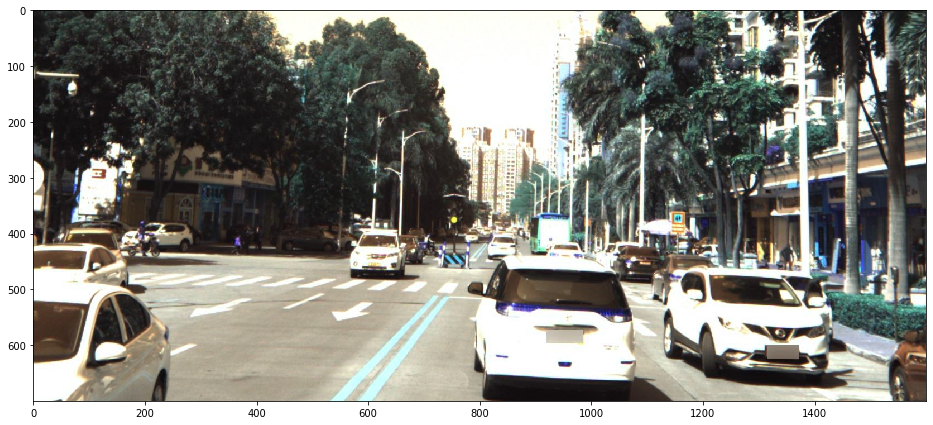

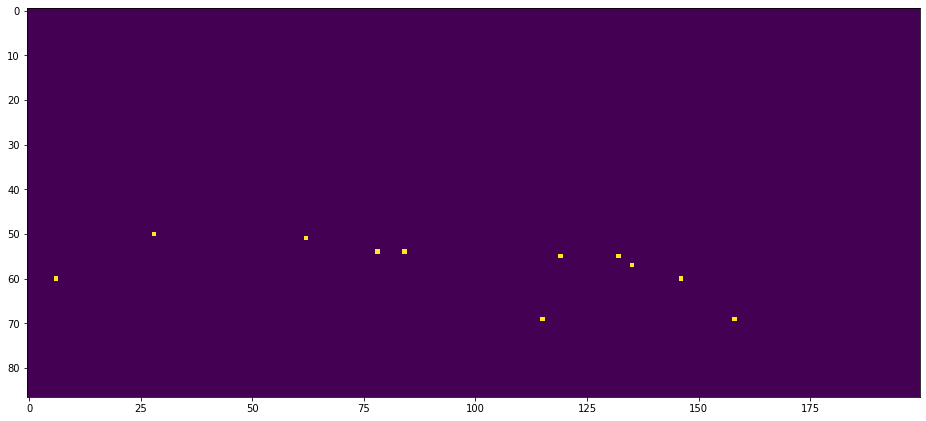

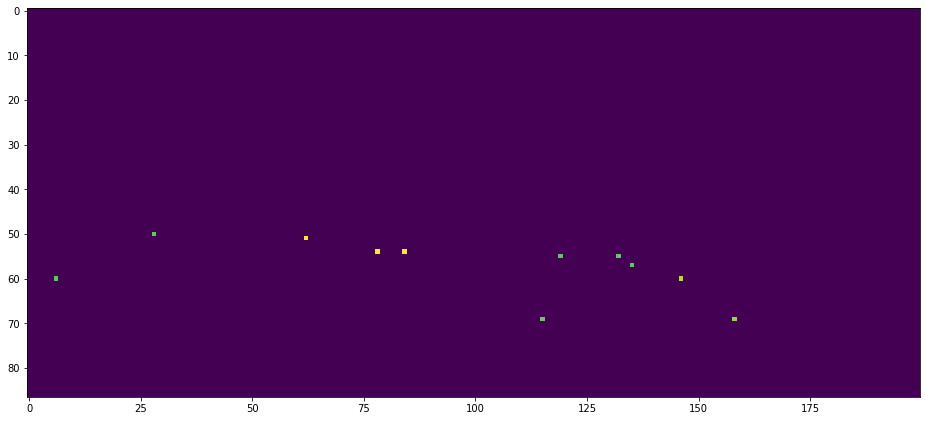

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]
plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [10]:
base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, 8)

setup_kwargs = {"model": model, "device": device}
if 'INITIAL_WEIGHTS' in os.environ:
    setup_kwargs["path"] = Path(os.environ["INITIAL_WEIGHTS"])
util.setup_model(**setup_kwargs)
print(setup_kwargs)

{'model': CentResnet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (do

In [76]:
n_epochs = 6

try:
    history = pickle.load(Path(os.environ["INITIAL_HISTORY"]).open('rb'))
    beg_epoch = math.ceil(history.index[-1])
except:
    history = pd.DataFrame()
    beg_epoch = 0
end_epoch = beg_epoch + n_epochs

In [77]:
%%time
from torch import optim
from torch.optim import lr_scheduler
import pandas as pd
import pickle


optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

for epoch in range(beg_epoch, end_epoch):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)
    
    with open('./history.pickle', 'wb') as fp:
        pickle.dump(history , fp)
    
    torch.save(model.state_dict(), f'./resnext50_{epoch}.pth')
    torch.save(model.state_dict(), './resnext50.pth')

-0.03461799140693245 0.016184400623732387
0.039298805308743745 -0.007562686191764367
0.26440039339481913 -0.03825002972810054
-0.01056426617903039 -0.03801844113165842
0.08258262153602125 0.07657189489681748
0.21480625086317762 -0.007218077274512069
0.073483214629535 -0.07266817459170127
0.06471785884950343 -0.03989757874524358
-0.046233916331063774 0.052306209290428285
-0.04717694337943179 -0.017196157232833187
0.17458247638395896 -0.021015632395323003
-0.0637960717474293 0.11357356597179091
0.0776320455641315 0.030140745574212424
-0.09315449200242298 0.2654695135974432
-0.1944135006324128 -0.15500303679955607
-0.036510008308943576 0.18018142603646403
0.1711621567190562 0.2211294086574931
0.03375327044662413 0.012354893321294025
-0.05906450704406563 -0.021786614086685585
0.048166088428376774 0.061592396116546766
-0.2510104982167545 -0.0673694354870662
-0.1559395409358233 -0.1283074197775811
-0.3473845969927911 -0.13265438432101107
0.3201490226599404 0.38115996893655435
0.4563183940822

KeyboardInterrupt: 

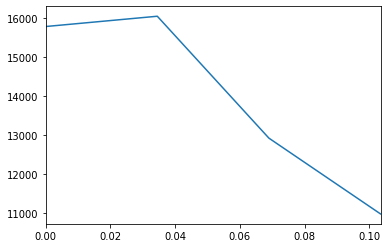

In [55]:
history['train_loss'].iloc[:].plot();

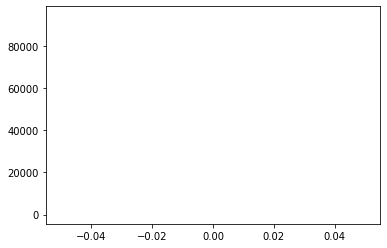

In [56]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

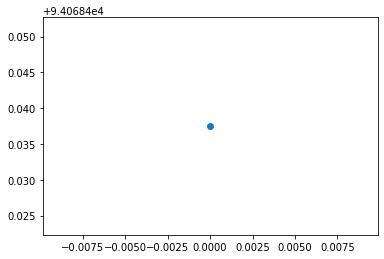

In [57]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

-0.03461799140693245 0.016184400623732387
0.039298805308743745 -0.007562686191764367
0.26440039339481913 -0.03825002972810054
-0.01056426617903039 -0.03801844113165842
0.08258262153602125 0.07657189489681748
0.21480625086317762 -0.007218077274512069
0.073483214629535 -0.07266817459170127
0.06471785884950343 -0.03989757874524358
-0.046233916331063774 0.052306209290428285
-0.04717694337943179 -0.017196157232833187
0.17458247638395896 -0.021015632395323003
-0.0637960717474293 0.11357356597179091
0.0776320455641315 0.030140745574212424
-0.09315449200242298 0.2654695135974432
-0.1944135006324128 -0.15500303679955607
-0.036510008308943576 0.18018142603646403
0.1711621567190562 0.2211294086574931
0.03375327044662413 0.012354893321294025


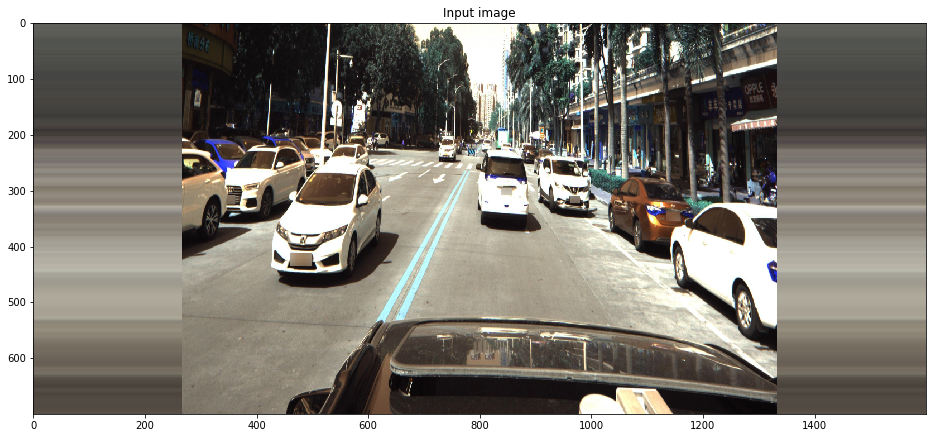

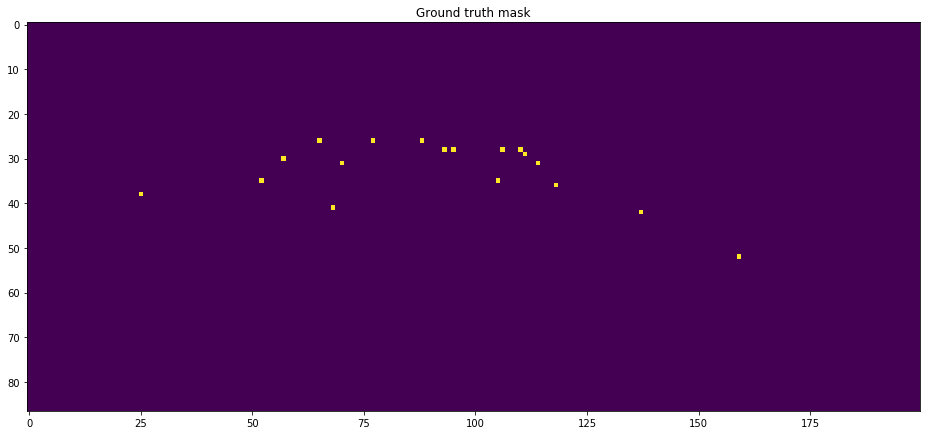

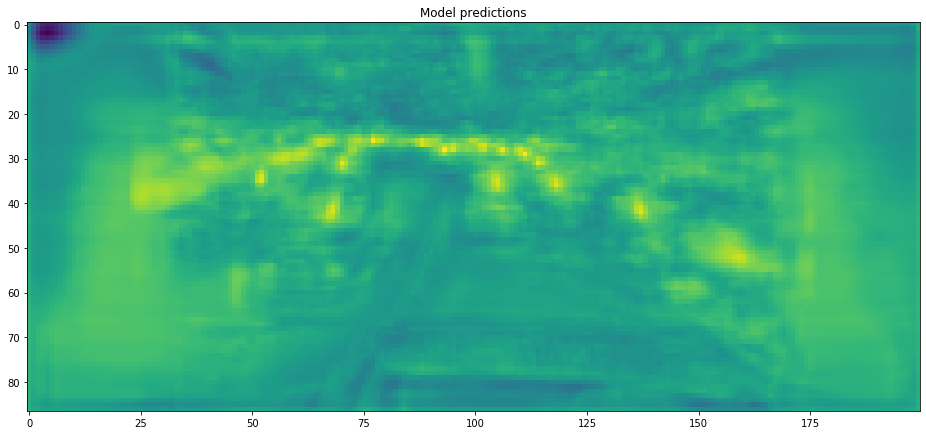

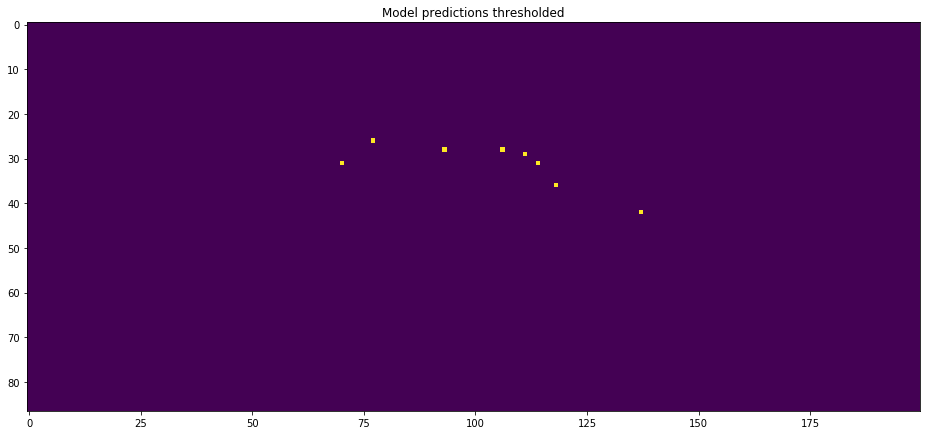

In [78]:
data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

0.0947102407278444 -0.03041153532559182
0.06473628010920773 -0.027585489664765817
0.06831747604109495 -0.051711547776004174
0.2791308027785213 -0.056465160727421804
-0.08664604612392023 -0.16362571375872292
-0.0051925215898762644 0.03688465105302541
-0.10123438186229805 -0.03630832027379949
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


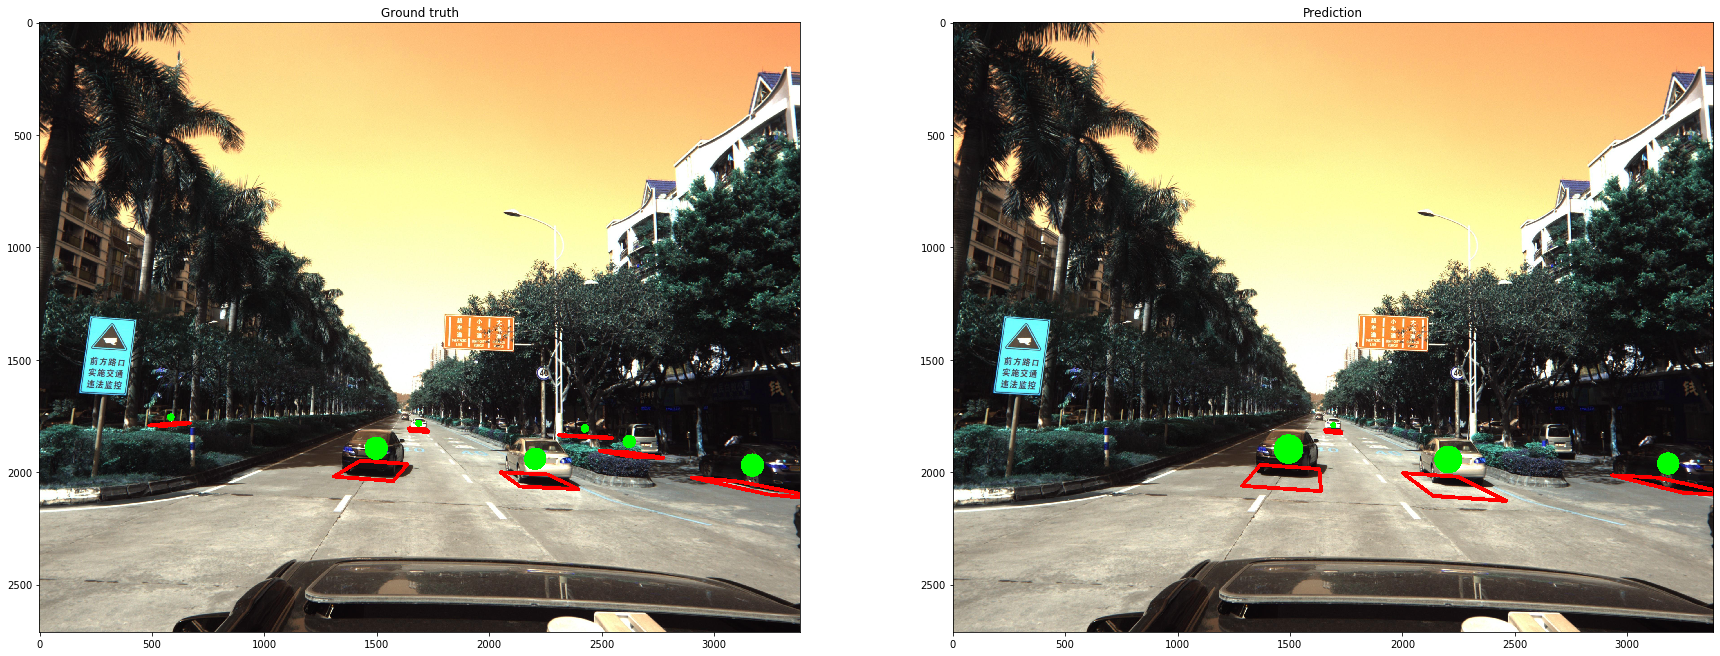

0.07183657428599943 -0.03220608029897276
0.00044154325859402377 0.049314513988799824
0.21009158640088632 0.18163962386369903
-0.16285625723732178 -0.2456081717791765
0.30734115499330894 -0.2645612423419088
-0.026040332295966584 -0.2303955472340089
0.20557599750934008 0.1176802629646243
0.3572820408795936 -0.012360123504954856
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


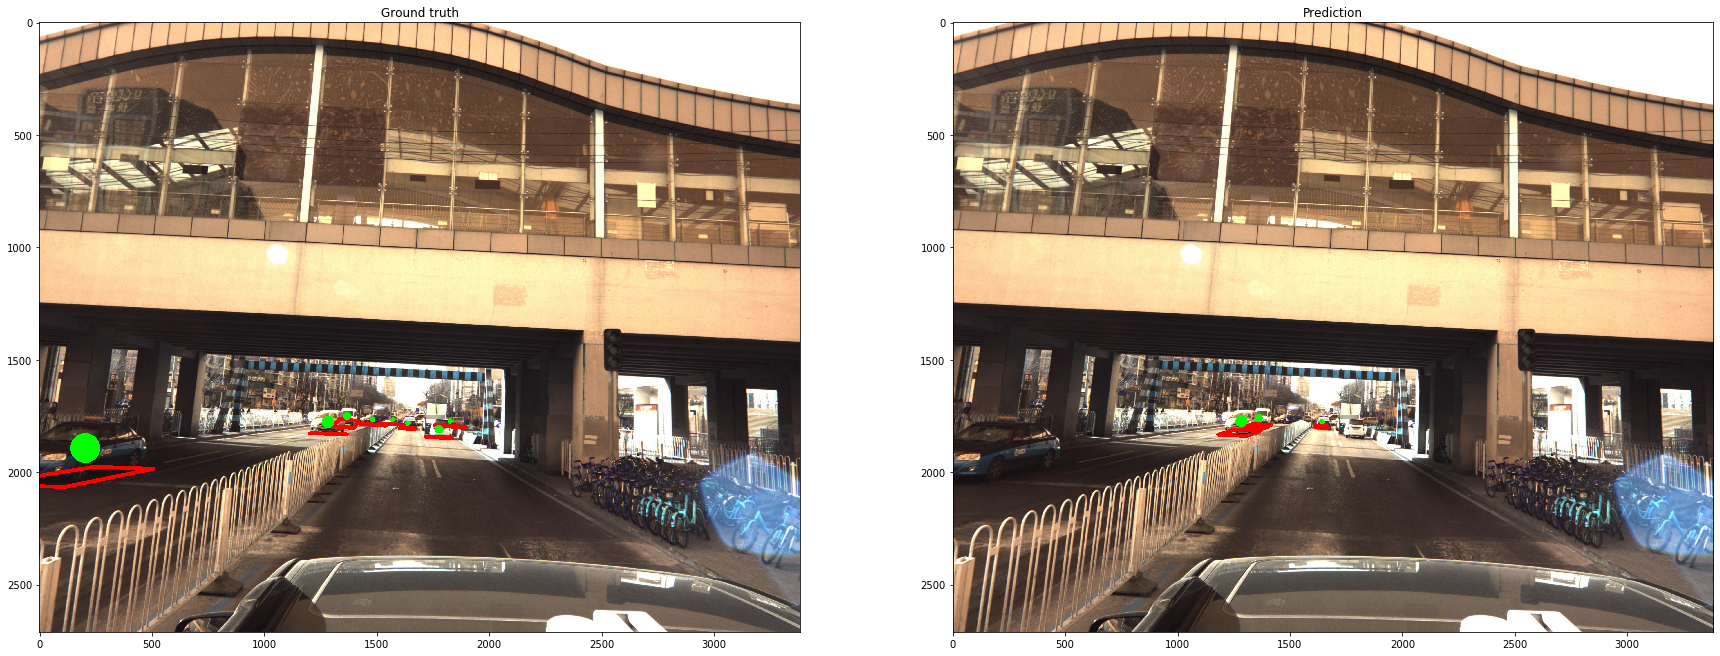

0.0256735854049559 0.024431012388080653
0.023860336717305586 -0.06716430919126548
-0.08603616380571921 0.0030597446206499512
0.2927871640759392 -0.0110274114482376
-0.05070827213765794 0.043713102278079674
0.30312674826372366 -0.22253575008991255
-0.10321432796753416 -0.13448921993325058
0.8556992952246727 0.6794026625168357
0.0524070559515426 -0.06940517317883366
0.1732551061242411 -0.10315863235978817
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


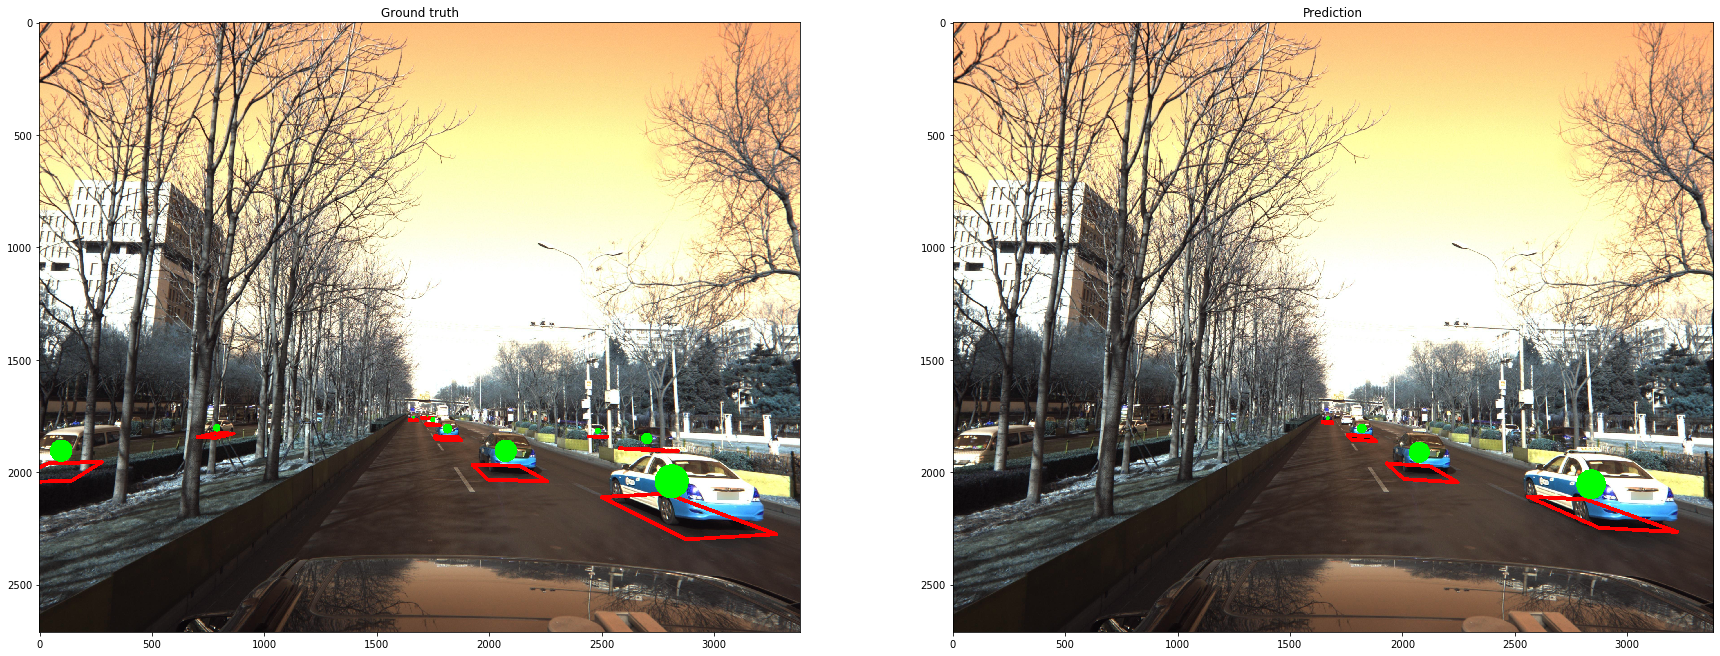

0.09912321433379034 0.032813952844484184
0.2175560231462157 0.10419122819987248
-0.12362017277957449 -0.15993741685125684
-0.2871471333374913 -0.033356045416345736
-0.2935946214573839 0.1796085893651842
0.16083078637619153 0.0009065726798169749
-0.031090482858935786 0.2850962436846185
0.4005558859711922 0.17046167697419357
0.16501556023508357 -0.04411160683473536
-0.20175348800761128 0.26418393004114016
0.22057725005323192 0.012599244727118375
0.1082835417572987 -0.01227516889710678
-0.06440690490503753 -0.01464717820741157
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 4.3392461e-04  0.0000000e+00 -7.3170012e-01]
 [ 0.0000000e+00  4.3367472e-04 -5.8762270e-01]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


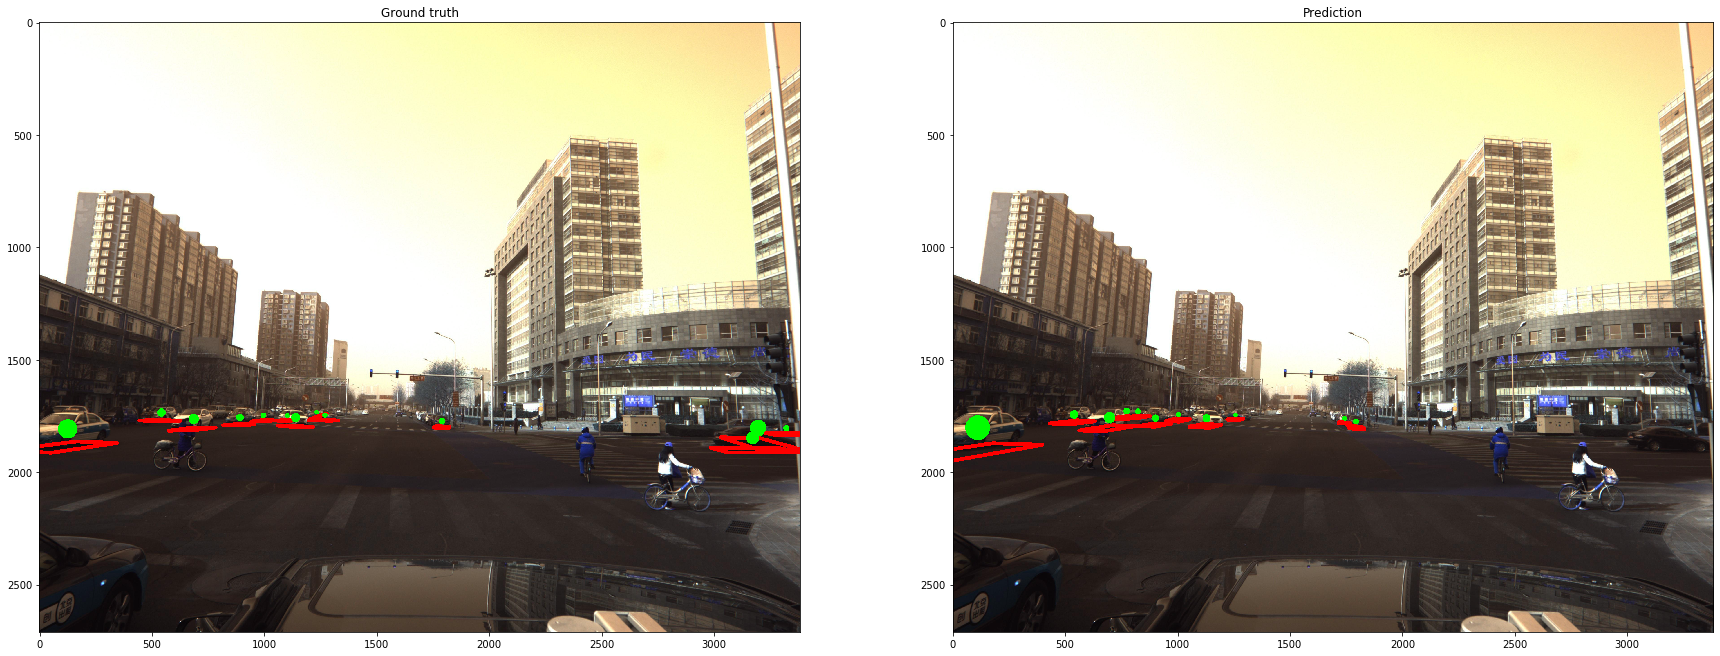

In [79]:
import gc
gc.collect()

for idx in range(4):
    data = dev_loader.dataset[idx]
    img, mask, regr = data["img"], data["mask"], data["regr"]
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    coords_pred = util.extract_coords(data, output[0])
    coords_true = util.extract_coords(data)

    img = io.load_image(dev_loader.dataset.dataset[idx].image_id)
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(graphics.draw_coords(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(graphics.draw_coords(img, coords_pred))
    plt.show()

In [22]:
c, r = 100, 28
est_point = np.array([0.4839196801185608, 11.381589621305466, 63.56151103973389])
adj_point = np.array([0.2519170151247247,11.833200956974606, 63.56151103973389])
affine_mat = dev_loader.dataset[0]['affine_mat']
camera_mat  = io.load_camera_matrix()

In [43]:
px = MODEL_SCALE * c
py = MODEL_SCALE * r
pp = np.array([py, px , 1])

In [44]:
np.linalg.inv(camera_mat) @ affine_mat @ pp

array([0.04441743, 0.14615493, 1.        ])

In [52]:
abc = adj_point @ camera_mat.T
#abc / abc[2]
abc

array([1.07760385e+05, 1.13410776e+05, 6.35615110e+01])

In [46]:
camera_mat

array([[2.3045479e+03, 0.0000000e+00, 1.6862379e+03],
       [0.0000000e+00, 2.3058757e+03, 1.3549849e+03],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [53]:
((affine_mat @ pp)[[1, 0, 2]] * est_point[2]) @ np.linalg.inv(camera_mat.T)

array([ 0.15892375, 11.95260908, 63.56151104])

In [54]:
dev_loader.dataset[0]["data"]

[{'id': 28,
  'yaw': 0.132443,
  'pitch': -0.0917681,
  'roll': -3.08344,
  'x': -1.61091,
  'y': 4.65303,
  'z': 19.9246},
 {'id': 35,
  'yaw': 0.16825,
  'pitch': -0.0178875,
  'roll': -3.098,
  'x': 4.61943,
  'y': 5.1905,
  'z': 20.4466},
 {'id': 35,
  'yaw': 0.168053,
  'pitch': 0.00418944,
  'roll': -3.05442,
  'x': 12.3663,
  'y': 5.10021,
  'z': 19.178},
 {'id': 76,
  'yaw': 0.126888,
  'pitch': 3.04207,
  'roll': 3.13769,
  'x': -27.9417,
  'y': 10.1657,
  'z': 58.5407},
 {'id': 16,
  'yaw': 0.132442,
  'pitch': 0.049517,
  'roll': -3.08343,
  'x': 0.0636926,
  'y': 11.1433,
  'z': 60.1279},
 {'id': 16,
  'yaw': 0.168254,
  'pitch': -1.57166,
  'roll': -3.098,
  'x': 16.667,
  'y': 10.125,
  'z': 51.7967},
 {'id': 46,
  'yaw': 0.16825,
  'pitch': 0.0477228,
  'roll': -3.09801,
  'x': 13.6279,
  'y': 7.38535,
  'z': 33.4872}]